In [ ]:
#  Steps of the work:

# Make a model with accessible parameters using TensorFlow 2.x
# Write an entropy loss and add it to the network parameters for training.
# Train a model by jointly optimizing its loss (e.g. cross entropy for classification) and the entropy for compressability.
# Compress the model parameters using Huffman coding.
# Analyze the results and trade-off between accuracy and compressability.
# Write a model wrapper that can read and write the compressed parameters.

# Notes:

# Can be started on simple datasets like MNIST.
# Can start from simple MLP NNs. And then extend to convs. The implementation should be generic enough so that it can support any layer.
# Bonus: add support for normalization layers: batch norm, instance norm, etc.

In [1]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [3]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Allocation of 17179869184 exceeds 10% of free system memory.

In [2]:
# generate a simple NN model

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

    
kernel_initializer = 'he_normal'
activation = "relu"

def get_model(chs=128):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=chs*2, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model



In [15]:
import dahuffman



In [3]:
# huffman code
class HuffmanNode:
    def __init__(self, freq, value=None):
        self.freq = freq
        self.value = value
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    pq = [HuffmanNode(freq, value) for value, freq in frequencies.items()]
    heapq.heapify(pq)

    while len(pq) > 1:
        left = heapq.heappop(pq)
        right = heapq.heappop(pq)
        parent = HuffmanNode(left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(pq, parent)

    return pq[0]

def generate_huffman_codes(node, prefix="", codes={}):
    if node.value is not None:
        codes[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", codes)
        generate_huffman_codes(node.right, prefix + "1", codes)

def compress_activations(activations):
    flat_activations = activations.flatten()
    frequencies = defaultdict(int)
    for value in flat_activations:
        frequencies[value] += 1

    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = {}
    generate_huffman_codes(huffman_tree, codes=huffman_codes)

    compressed_activations = []
    for value in flat_activations:
        compressed_activations.append(huffman_codes[value])

    return compressed_activations, huffman_codes


# Compress activations
# activations = compNN.get_activations()  # Get activations from the model or compNN
# compressed_activations, huffman_codes = compress_activations(activations)


In [10]:
#     To estimate the histogram, we first remove outliers in the
# activations if the samples are outside the range [μ−3σ; μ+3σ]
from histogram import calculate_histogram, test_histogram, calculate_histogram_range

def calculate_entropy(variables, eps=0.0):
    min_h, max_h = calculate_histogram_range(variables)
    flat_vars = tf.reshape(variables, (-1,1))    
    hist = calculate_histogram(flat_vars, min_h, max_h)
    
    probs = hist / tf.reduce_sum(hist)
    entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
    return entropy, (min_h, max_h)


def calc_sparsity_regularization(self, inputs, regularization_coefficient=1e-2):
    abs_inputs = tf.abs(inputs)
    l1_norm = tf.reduce_sum(abs_inputs, axis=0)
    print(tf.shape(inputs))
    num_activations = tf.cast(tf.shape(inputs)[0], dtype=tf.float32)
    regularization_loss = regularization_coefficient / num_activations * tf.reduce_sum(l1_norm)
    
    return regularization_loss

class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        entropy = 0
#         for l in self.net_model.layers:
#             #TODO: if layer is dense:
#             for v in l.trainable_variables:
#                 # here you have a set of variable for which you can calculate the histogram and entropy
#                 entropy += calculate_entropy(v)
#         return 0
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy

        return entropy
    
    def regularization_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        rg_loss = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_regularization_loss = calc_sparsity_regularization(v)
                    rg_loss += v_regularization_loss

        return rg_loss
    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)
#             regularization_loss = self.sparsity_regularization(images)

        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

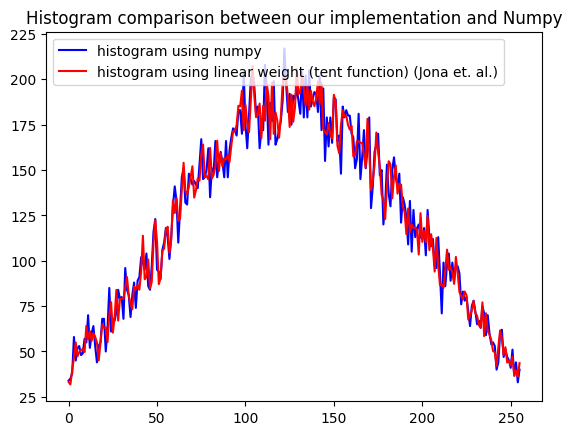

In [12]:
from histogram import visualize_histogram
variables=model.layers[3].variables[0]
visualize_histogram(variables)

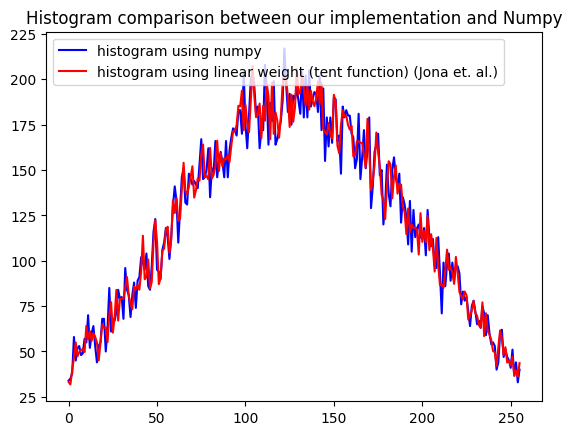

In [11]:
from histogram import visualize_histogram
variables=model.layers[3].variables[0]
visualize_histogram(variables)

In [8]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)

  27/1875 [..............................] - ETA: 40:26 - loss: 20.7670

KeyboardInterrupt: 

In [53]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.02000000000001


In [56]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.61


In [ ]:
 17.7708
 17.7171
 17.6588
 